In [1]:
%run ../input/python-recipes/dhtml.py
dhtml('Code Modules, Functions, & Settings',c10,f2,fs8)

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,h5py,os,torch
import tensorflow_hub as th,tensorflow as tf
import seaborn as sn,pylab as pl
from tensorflow.keras.preprocessing \
import image as tkimg
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from PIL import Image
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
from IPython.core.magic import register_line_magic

In [3]:
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
files_path='../input/flower-color-images/flowers/flowers/'
h5file='FlowerColorImages2.h5'
img_size,img_size2=128,64
train_csv,valid_csv,test_csv=\
'train.csv','valid_csv','test.csv'
images_path='../input/flower-color-images/flowers/'
model_weights='/checkpoints'
handle_base='mobilenet_v2_100_128'
mhandle='https://tfhub.dev/google/imagenet/'+\
        '{}/classification/4'.format(handle_base)

In [4]:
def images2array(files_path,img_size,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if (img_path[-4:]=='.png'):
            img=tkimg.load_img(
                img_path,grayscale=grayscale,
                target_size=(img_size,img_size))
        img=tkimg.img_to_array(np.squeeze(img))
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),dtype='float32')
class FlowersData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['label'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        img=img.convert('RGB')
        if self.transform is not None:
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
@register_line_magic
def display_images(n):
    n=int(n)
    fig=pl.figure(figsize=(9,11))
    randch=np.random\
    .choice(180,size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(3,n//3,i+1,
                           xticks=[],yticks=[])
        ax.imshow(images[idx])
        label=names[labels[idx]]
        ti='{} \n({})'.format(labels[idx],label)
        ax.set_title(ti)
    pl.show()
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(9,3))
        for i in range(n,n+4):
            ax=fig.add_subplot(1,4,i-n+1,\
            xticks=[],yticks=[],\
            title=names[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break

In [5]:
def cb(fw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=fw,save_best_only=True,verbose=2,
        save_weights_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=7,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [6]:
dhtml('Data Processing',c10,f2,fs8)

In [7]:
flist=sorted(os.listdir(files_path))
n=np.random.randint(100)
print(flist[n:n+5])

['00_031.png', '00_032.png', '00_033.png', '00_034.png', '00_035.png']


In [8]:
labels=[int(el[:2]) for el in flist]
labels=np.array(labels,dtype='int32')
images=images2array(files_path,img_size)
names=['phlox','rose','calendula','iris','Shasta daisy',
       'bellflower','viola','Goldquelle','peony','aquilegia',
       'rhododendron','passiflora','tulip','water lily',
       'lilium','veronica chamaedrys','cosmos',
       'aster annual','aster perennial','snowdrop']
num_classes=len(names)

=>=>=>=>=>=>=>=>=>=>=>

In [9]:
maxlen=max([len(n) for n in names])
bnames=np.array([np.string_(name) for name in names])
with h5py.File(h5file,'w') as f:
    f.create_dataset('images',data=images,compression='gzip')
    f.create_dataset('labels',data=labels,compression='gzip')
    f.create_dataset('names',data=bnames,dtype='S%d'%maxlen,
                     compression='gzip')
    f.close()
print('\nfile size: %s'%list(os.stat(h5file))[6])


file size: 39405806


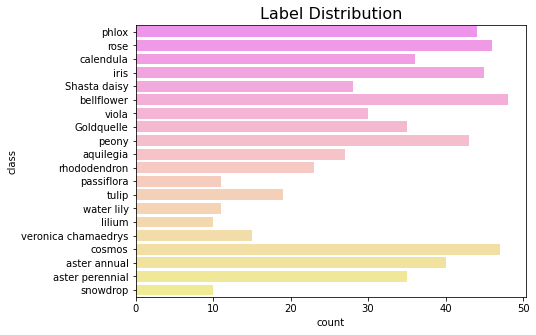

In [10]:
df=pd.DataFrame(labels,columns=['label'])
df['class']=[names[l] for l in labels]
pl.figure(figsize=(7,5))
sn.countplot(y='class',data=df,
             palette='spring',alpha=.5)
ti='Label Distribution'
pl.title(ti,fontsize=16); 

In [11]:
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

,train,valid,test
0,"(483, 128, 128, 3)","(60, 128, 128, 3)","(60, 128, 128, 3)"
1,float32,float32,float32
2,"(483,)","(60,)","(60,)"
3,int32,int32,int32


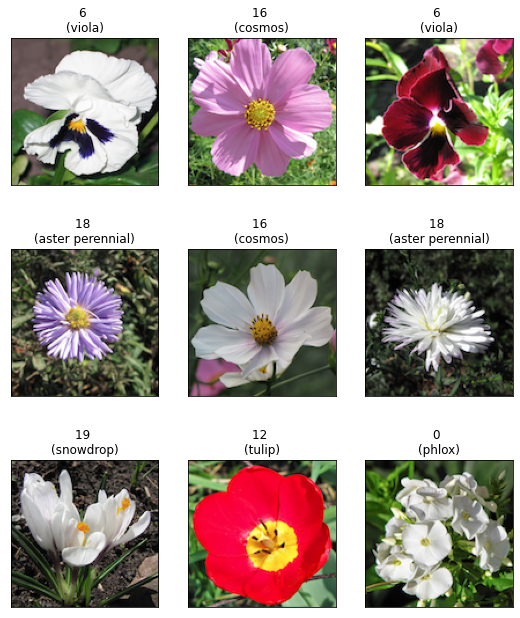

In [12]:
%display_images 9

In [13]:
files=[os.path.relpath(os.path.join(dirpath,fn),images_path) \
for (dirpath,dirnames,filenames) in os.walk(images_path) \
for fn in filenames if fn.endswith('.png')]
d={'label':[],'flower':[],'file':[],'path':[]}
for f in files:
    _,fn=f.split('/')
    label=int(fn[:2]); flower=names[label]        
    d['label'].append(label)
    d['flower'].append(flower)
    d['file'].append(fn)
    d['path'].append(f)
df=pd.DataFrame.from_dict(d)
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test[:df_test.shape[0]//2].to_csv(test_csv)
df_test[df_test.shape[0]//2:].to_csv(valid_csv)
num_classes=np.unique(df['label'].values).shape[0]
print([num_classes,len(files)]); df_test.head()

[20, 603]


,label,flower,path
file,,,
07_020.png,7,Goldquelle,flowers/07_020.png
05_041.png,5,bellflower,flowers/05_041.png
16_025.png,16,cosmos,flowers/16_025.png
07_016.png,7,Goldquelle,flowers/07_016.png
16_047.png,16,cosmos,flowers/16_047.png


In [14]:
batch_size=16; num_workers=4; grayscale=False
trans=transforms\
.Compose([transforms.Resize((img_size2,img_size2)),
          transforms.ToTensor()])
train=FlowersData(
    csv_path=train_csv,img_dir=images_path,transform=trans)
test=FlowersData(
    csv_path=test_csv,img_dir=images_path,transform=trans)
valid=FlowersData(
    csv_path=valid_csv,img_dir=images_path,transform=trans)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers),
             'valid':tdl(dataset=valid,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers)}

Image dimensions: torch.Size([16, 3, 64, 64])
Label dimensions: torch.Size([16])


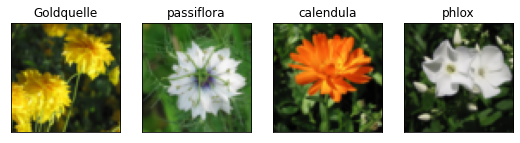

In [15]:
%display_examples valid

In [16]:
dhtml('Classifiers',c10,f2,fs8)

In [17]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((pix,pix,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(
        optimizer='adam', metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model

In [18]:
kmodel=premodel(
    img_size,2048,mhandle,num_classes,'softmax',
    'sparse_categorical_crossentropy')
history=kmodel.fit(
    x=x_train,y=y_train,batch_size=24,epochs=50,
    callbacks=cb(model_weights),
    validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 5,633,341
Trainable params: 5,599,229
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.2343 - accuracy: 0.5176
Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to /checkpoints
21/21 [==============================] - 23s 1s/step - loss: 2.2343 - accuracy: 0.5176 - val_loss: 3.7084 - val_accuracy: 0.4167
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.8776 - accuracy: 0.6998
Epoch 00002: val_accuracy did not improve from 0.41667
21/21 [==============================] - 21s 999ms/step - loss: 1.8776 - accuracy: 0.6998 - val_loss: 15.9036 - val_accuracy: 0.2167
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.5765 - accuracy: 0.7226
Epoch 00003: val_accuracy did not improve from 0.41667
21/21 [==============================] - 21s 1s/step - loss: 1.5765 - accuracy: 0.7226 - val_loss: 11.5954 - val_accuracy: 0.1333
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.9463 - accuracy: 0.8240
Epoch 00004: val_accuracy did not im

<Figure size 432x288 with 0 Axes>

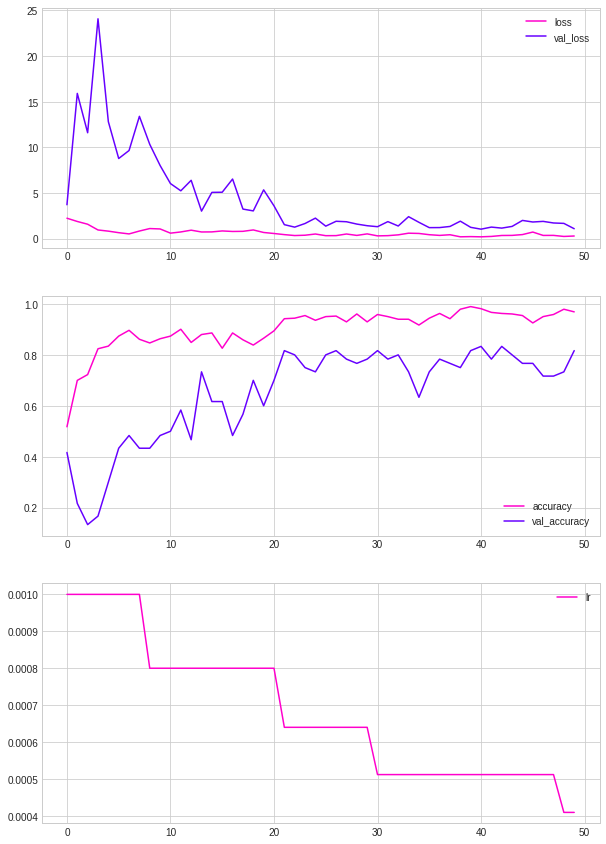

In [19]:
%run ../input/python-recipes/keras_history_plot.py
keras_history_plot(history,10,c10)

In [20]:
kmodel.load_weights(model_weights)
kmodel.evaluate(x_test,y_test,verbose=0)

[1.1810170412063599, 0.8833333253860474]

In [21]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [23]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [24]:
%train_run 25

Epoch: 001/025 | Batch: 000/031 | Cost: 3.1196
Epoch: 001/025 | Batch: 010/031 | Cost: 2.3251
Epoch: 001/025 | Batch: 020/031 | Cost: 2.2199
Epoch: 001/025 | Batch: 030/031 | Cost: 1.9027
Epoch: 001/025
train acc/loss: 58.85%/1.47 valid acc/loss: 47.46%/1.72
Epoch: 002/025 | Batch: 000/031 | Cost: 1.8065
Epoch: 002/025 | Batch: 010/031 | Cost: 1.6022
Epoch: 002/025 | Batch: 020/031 | Cost: 1.7475
Epoch: 002/025 | Batch: 030/031 | Cost: 1.6009
Epoch: 002/025
train acc/loss: 70.78%/1.12 valid acc/loss: 52.54%/1.59
Epoch: 003/025 | Batch: 000/031 | Cost: 1.4205
Epoch: 003/025 | Batch: 010/031 | Cost: 1.4889
Epoch: 003/025 | Batch: 020/031 | Cost: 1.0776
Epoch: 003/025 | Batch: 030/031 | Cost: 0.4812
Epoch: 003/025
train acc/loss: 76.95%/0.86 valid acc/loss: 54.24%/1.42
Epoch: 004/025 | Batch: 000/031 | Cost: 1.2407
Epoch: 004/025 | Batch: 010/031 | Cost: 1.0910
Epoch: 004/025 | Batch: 020/031 | Cost: 1.2130
Epoch: 004/025 | Batch: 030/031 | Cost: 0.8226
Epoch: 004/025
train acc/loss: 82.7

In [25]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 98.97% || test acc: 68.97%
